In [9]:
#From https://github.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/blob/main/Chapter_13.ipynb

import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

In [10]:
#Causal graph
causal_graph = nx.DiGraph([
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'totalBandwidth'),
                           ('ihave', 'gossipBandwidth'),
                           ('iwant', 'gossipBandwidth'),
                           ('gossipBandwidth', 'totalBandwidth'),
                           ('messageReceived', 'messageBandwidth'),
                           ('messageBandwidth', 'totalBandwidth')
                         ])

#prune, graft, iwant, ihave, messageReceived, messageOverhead, propagationTime, messageBandwidth, gossipBandwidth, totalBandwidth


In [11]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
['prune', 'graft', 'propagationTime', 'messageReceived', 'messageOverhead', 'totalBandwidth', 'ihave', 'gossipBandwidth', 'iwant', 'messageBandwidth']


In [12]:
#get the experiments ids
data = pd.read_csv('../../experiments/experiments_filtered.csv',header=0, index_col=0)
experiments = pd.DataFrame(data)

reference = experiments[experiments['parameter'].str.match('reference')]

reference.head(100)

,experiment,originalStart,originalEnd,topology,parameter,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,start,end,startUnix,endUnix
2,390,2023-10-04 18:52:03.080773000,2023-10-04 19:22:03.086651800,unl,reference,8,6,12,4,8,2,0.25,1.0,2023-10-04 18:59:33.080773000,2023-10-04 19:14:33.086651800,1696445973,1696446873
3,391,2023-10-04 19:25:37.153339900,2023-10-04 19:55:37.155585600,unl,reference,8,6,12,4,8,2,0.25,1.0,2023-10-04 19:33:07.153339900,2023-10-04 19:48:07.155585600,1696447987,1696448887
6,505,2023-11-07 18:12:32.614239000,2023-11-07 18:42:32.616707000,unl,reference,8,6,12,4,8,2,0.25,1.0,2023-11-07 18:20:02.614239000,2023-11-07 18:35:02.616707000,1699381202,1699382102
7,506,2023-11-07 18:46:01.613382700,2023-11-07 19:16:01.615839300,unl,reference,8,6,12,4,8,2,0.25,1.0,2023-11-07 18:53:31.613382700,2023-11-07 19:08:31.615839300,1699383211,1699384111
86,447,2023-10-06 12:44:53.577371600,2023-10-06 13:14:53.584453300,general,reference,8,6,12,4,8,2,0.25,1.0,2023-10-06 12:52:23.577371600,2023-10-06 13:07:23.584453300,1696596743,1696597643
87,448,2023-10-06 13:18:27.160736500,2023-10-06 13:48:27.164275500,general,reference,8,6,12,4,8,2,0.25,1.0,2023-10-06 13:25:57.160736500,2023-10-06 13:40:57.164275500,1696598757,1696599657
88,449,2023-10-06 13:52:01.692042100,2023-10-06 14:22:01.702846800,general,reference,8,6,12,4,8,2,0.25,1.0,2023-10-06 13:59:31.692042100,2023-10-06 14:14:31.702846800,1696600771,1696601671
91,563,2023-11-09 18:01:13.628179400,2023-11-09 18:31:13.632110500,general,reference,8,6,12,4,8,2,0.25,1.0,2023-11-09 18:08:43.628179400,2023-11-09 18:23:43.632110500,1699553323,1699554223


In [13]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../GenerateDatasets/consolidated.csv',header=0, index_col=0)
cons = pd.DataFrame(data)

# cons.head(100)
consolidated = cons.loc[cons['experiment'].isin([390,391,505,506])]

# consolidated = consolidated.drop(columns=['experiment'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})#, 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
consolidated = consolidated.drop(columns=['top', 'd', 'dhi', 'dlo','dscore','dout','gossipFactor','dlazy','interval'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['prune', 'graft', 'propagationTime', 'messageReceived', 'messageOverhead', 'totalBandwidth', 'ihave', 'gossipBandwidth', 'iwant', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,experiment,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,topology
0,390,1856.745902,3748.0,520.0,0.0,0.0,0.0,0.0,521.0,8512.0,4243.0,0
1,390,1979.913793,478.0,59.0,0.0,0.0,0.0,347.0,59.0,1234.0,697.0,0
2,390,1670.648148,3986.0,542.0,0.0,0.0,0.0,0.0,547.0,9027.0,4494.0,0
3,390,1710.708333,472.0,72.0,0.0,0.0,0.0,351.0,72.0,1259.0,715.0,0
4,390,1879.665217,3703.0,503.0,0.0,0.0,0.0,0.0,505.0,8369.0,4161.0,0
5,390,1723.305556,538.0,73.0,0.0,0.0,0.0,347.0,73.0,1385.0,774.0,0
6,390,1816.257895,3430.0,465.0,0.0,0.0,0.0,0.0,465.0,7774.0,3879.0,0
7,390,1556.234783,786.0,115.0,0.0,0.0,0.0,342.0,115.0,1956.0,1055.0,0
8,390,2597.587302,3456.0,460.0,0.0,0.0,0.0,0.0,464.0,7833.0,3913.0,0
9,390,1654.754386,779.0,115.0,0.0,0.0,0.0,343.0,115.0,1947.0,1053.0,0


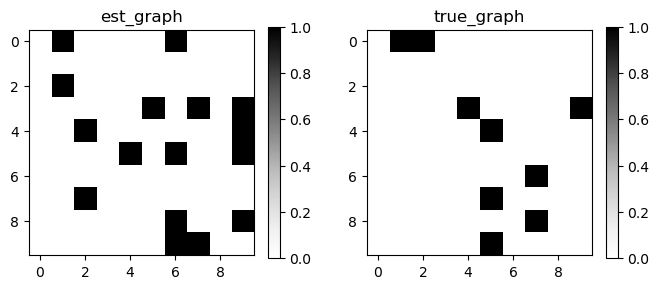

{'fdr': 0.875, 'tpr': 0.2222, 'fpr': 0.3889, 'shd': 19, 'nnz': 16, 'precision': 0.125, 'recall': 0.2222, 'F1': 0.16, 'gscore': 0.0}


In [14]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
# priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
#                             (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
#                             (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
#                             (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
#                             (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
#                             (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
#                             (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
#                             (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
#                             (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
#                             (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15),(14,4),(16,17),(16,18)])
# priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original')#, priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

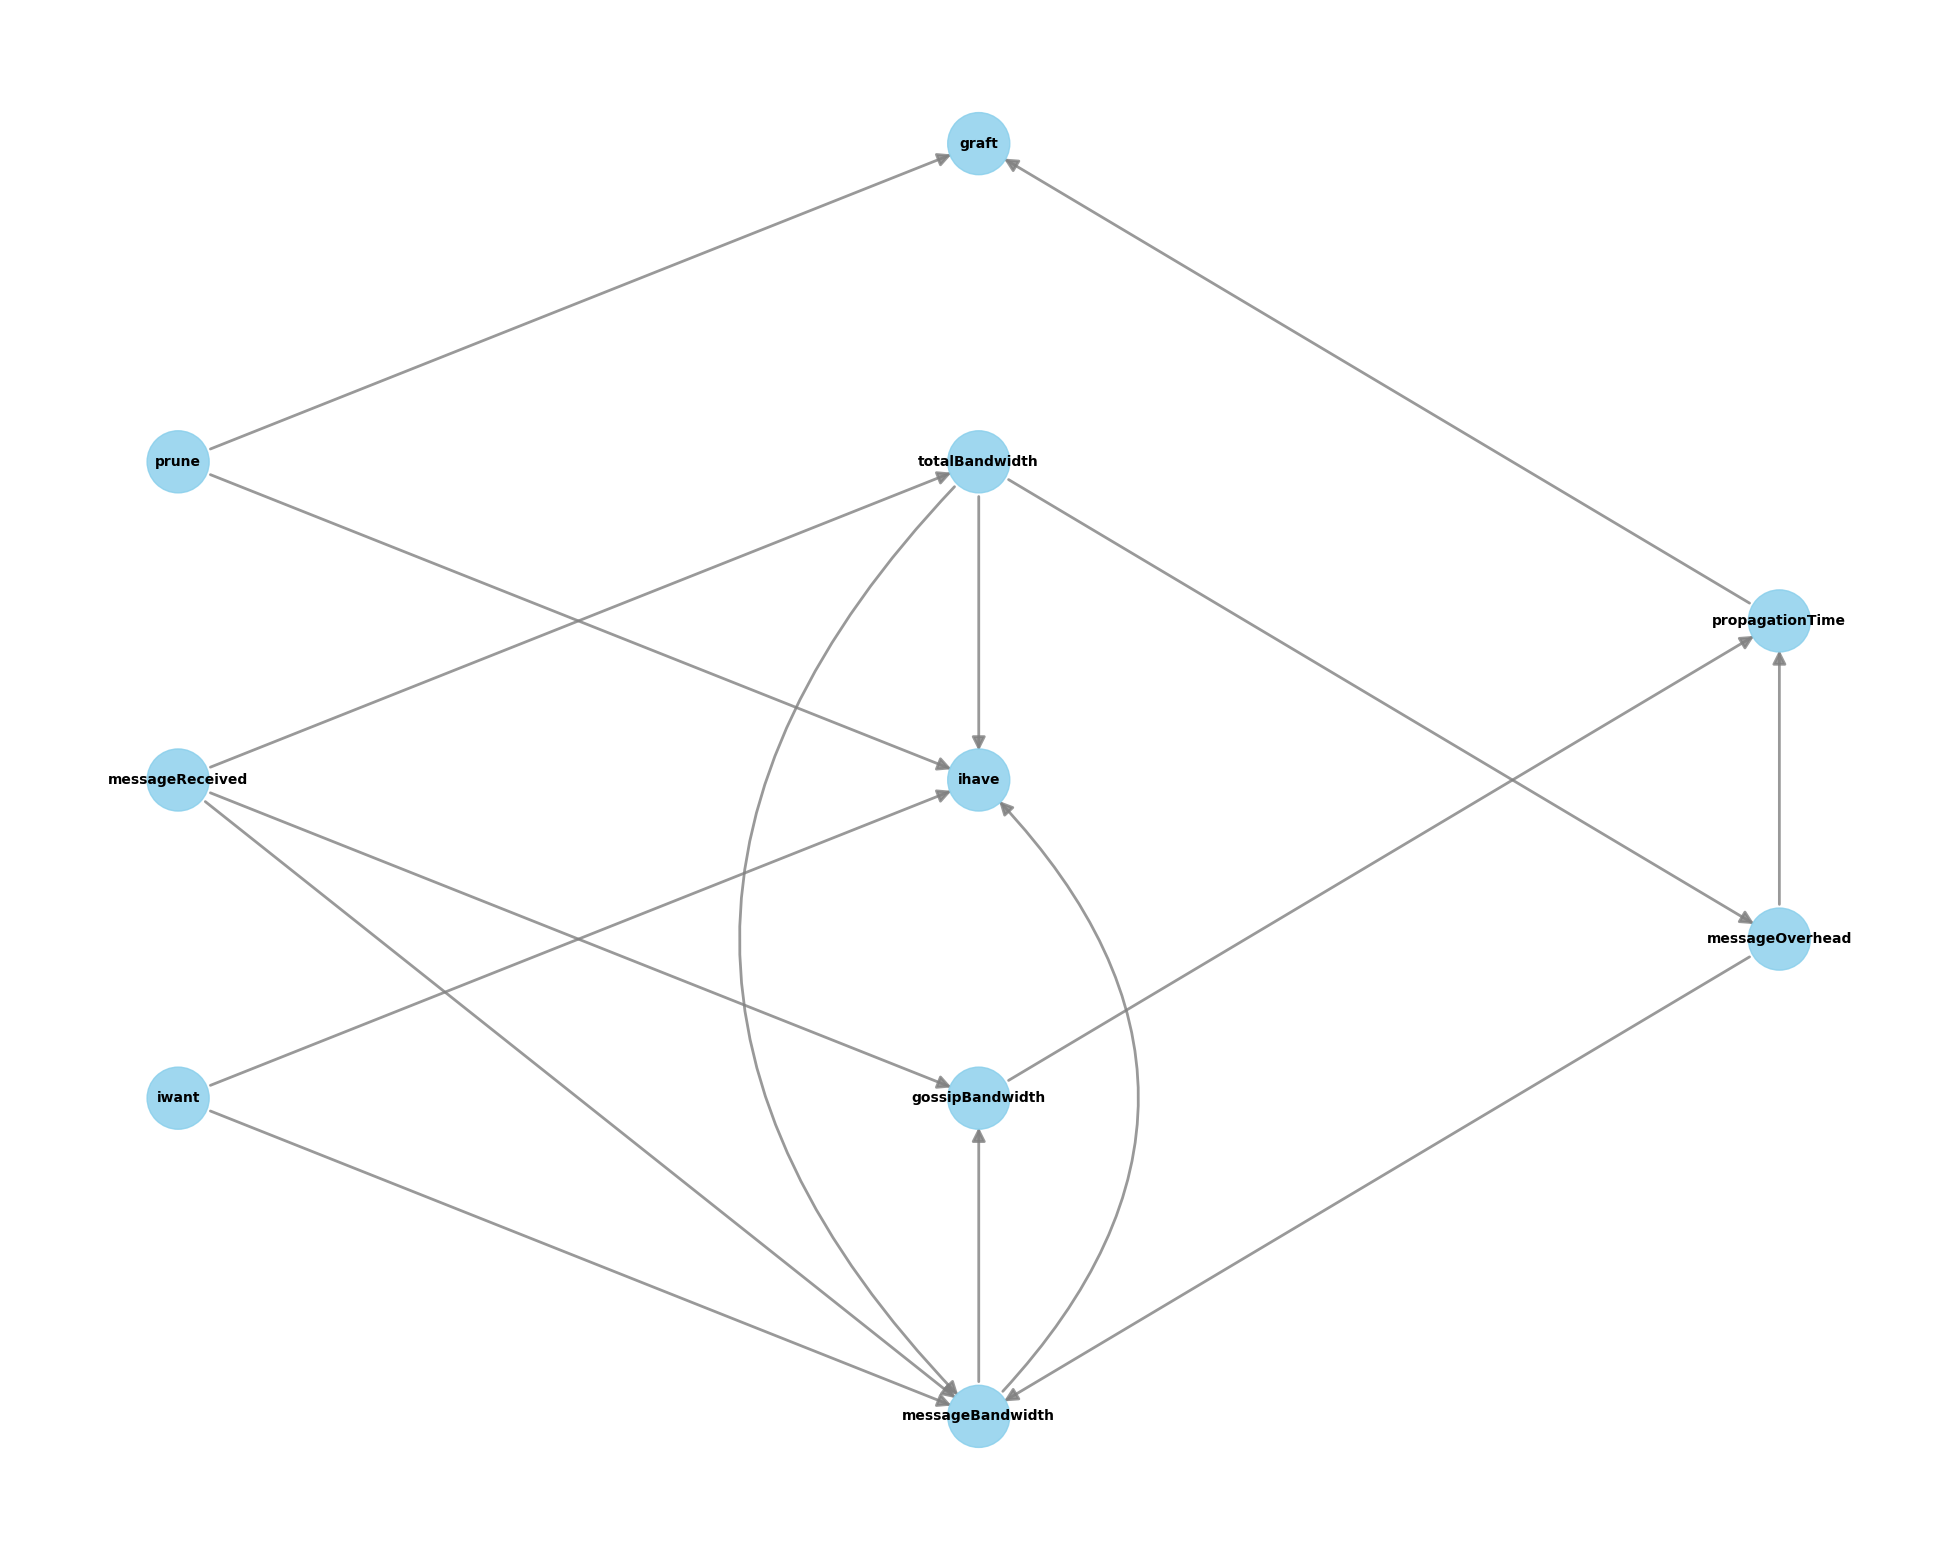

In [15]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {
            0:'prune', 
            1:'graft', 
            2:'propagationTime', 
            3:'messageReceived', 
            4:'messageOverhead', 
            5:'totalBandwidth', 
            6:'ihave', 
            7:'gossipBandwidth', 
            8:'iwant', 
            9:'messageBandwidth'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [17]:
# Instantiate GES
ges = GES(criterion='bic')

# Train
ges.learn(X)

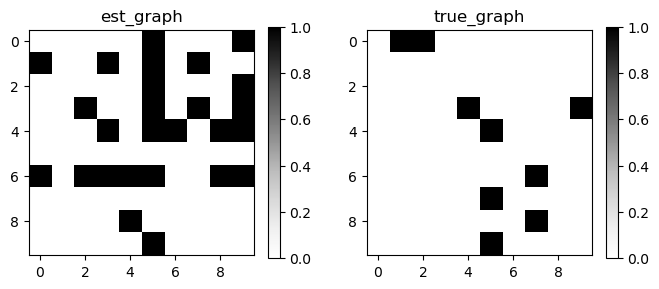

In [18]:
# Visualize
GraphDAG(
    est_dag=ges.causal_matrix, 
    true_dag=true_causal_matrix)

plt.show()

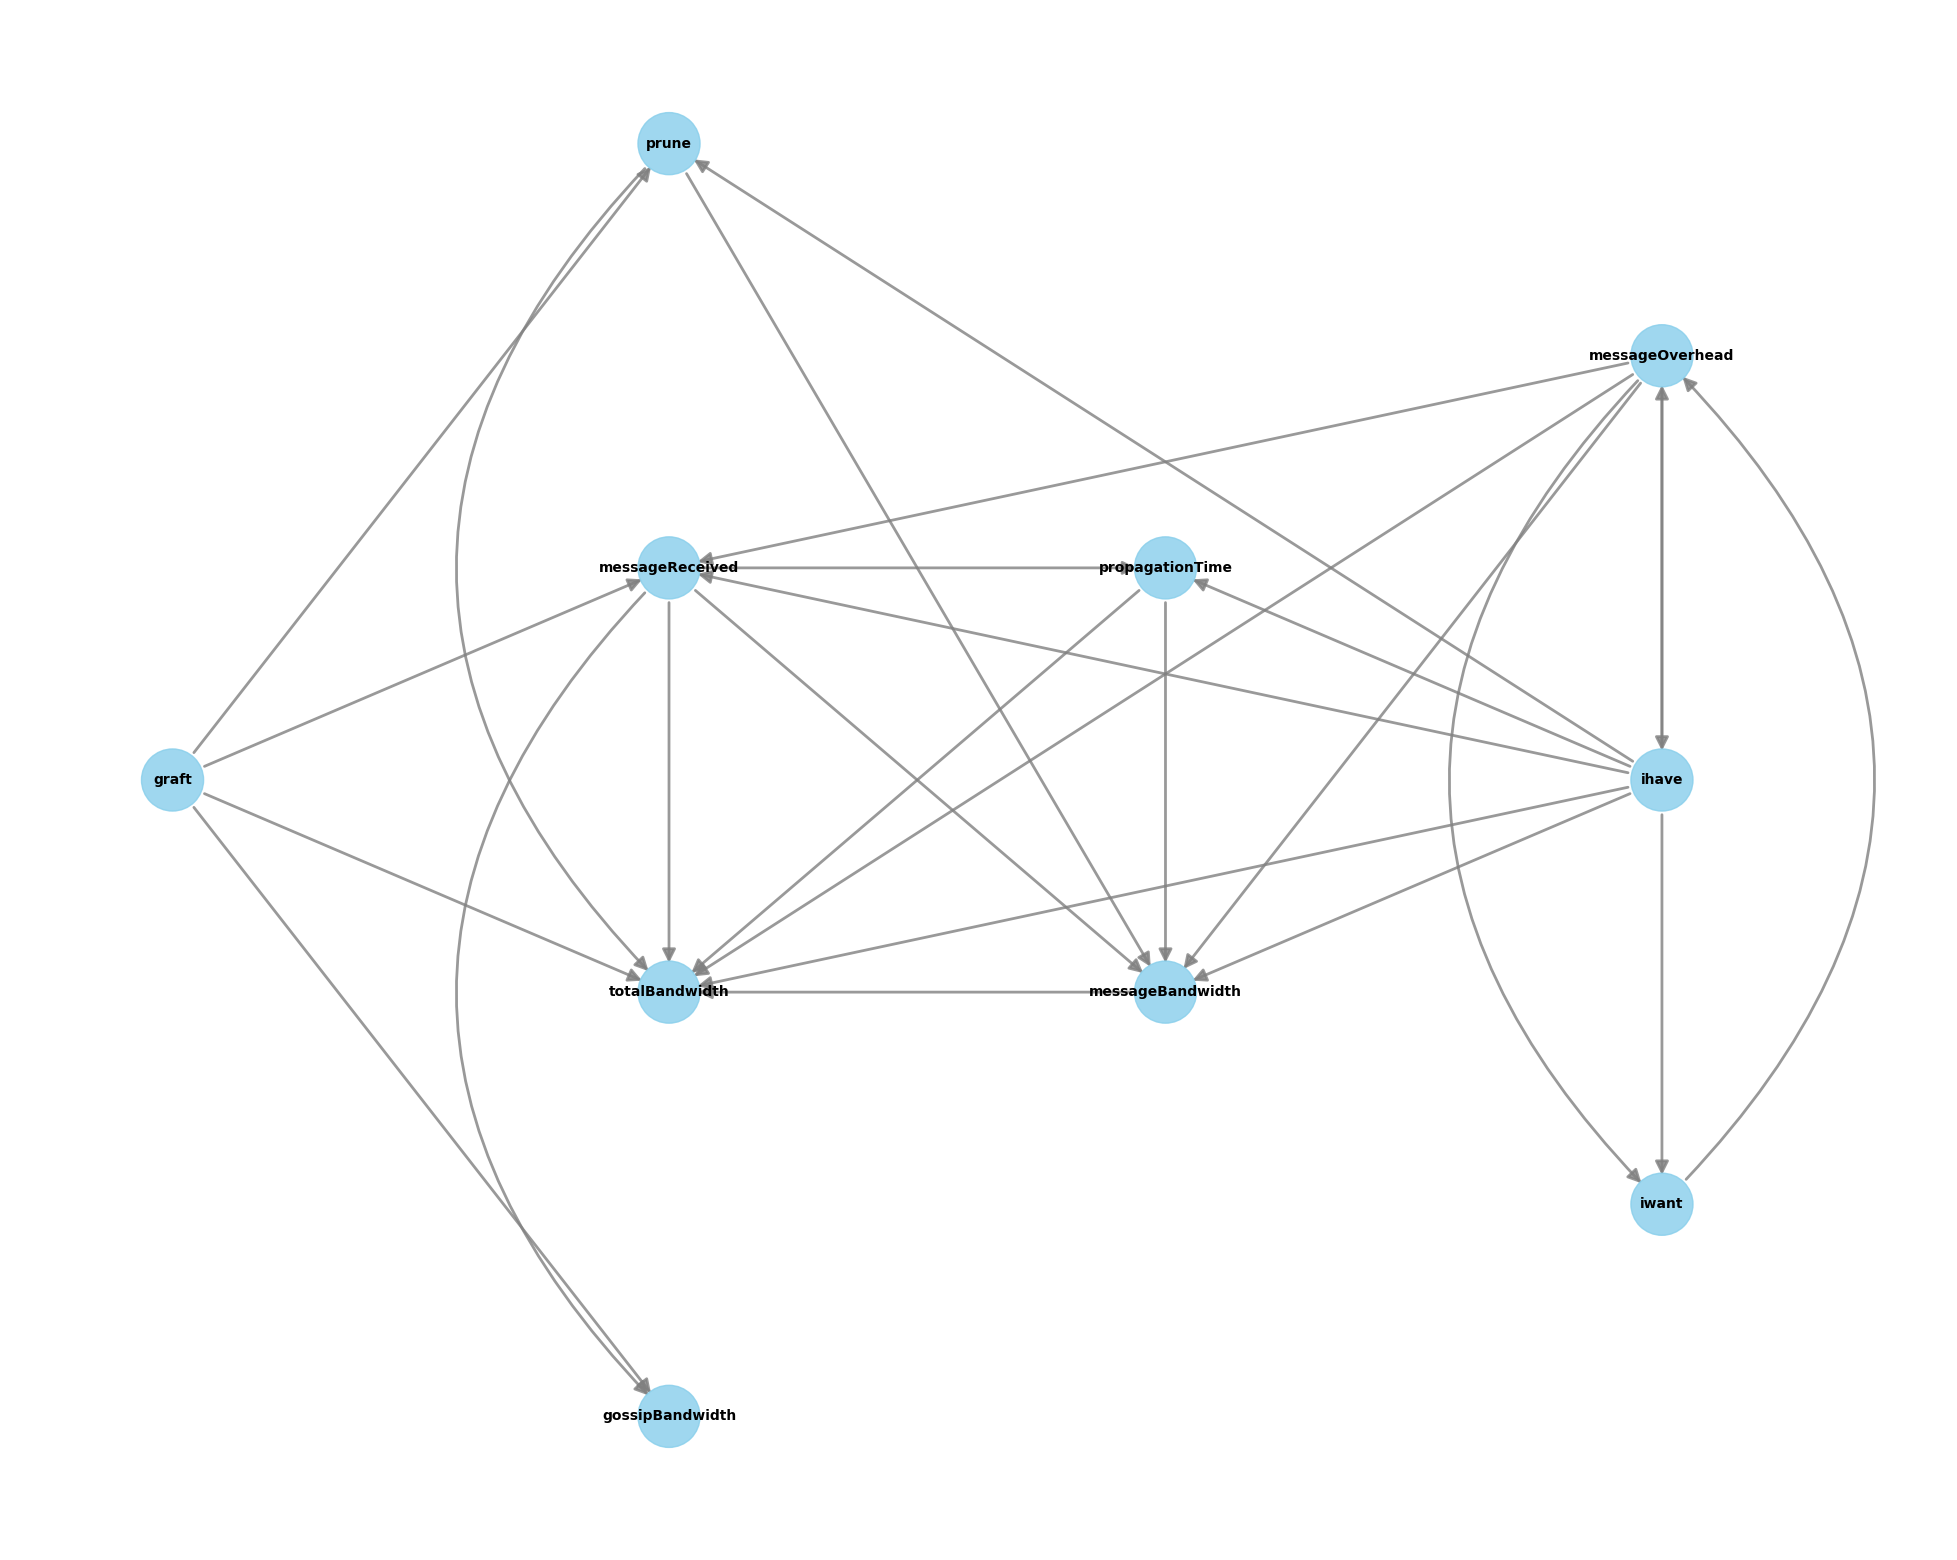

In [22]:
learned_causal_graph = nx.from_numpy_array(ges.causal_matrix, create_using=nx.DiGraph)

mapping = {
            0:'prune', 
            1:'graft', 
            2:'propagationTime', 
            3:'messageReceived', 
            4:'messageOverhead', 
            5:'totalBandwidth', 
            6:'ihave', 
            7:'gossipBandwidth', 
            8:'iwant', 
            9:'messageBandwidth'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "ges.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

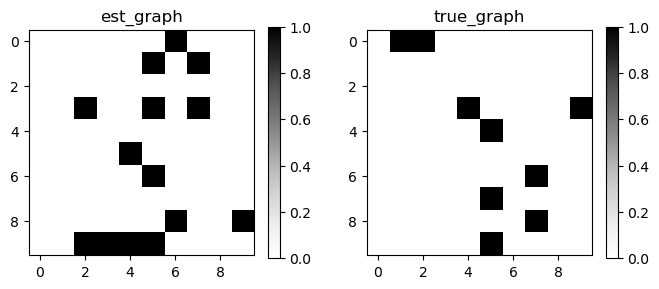

{'fdr': 0.9286, 'tpr': 0.1111, 'fpr': 0.3611, 'shd': 19, 'nnz': 14, 'precision': 0.0714, 'recall': 0.1111, 'F1': 0.087, 'gscore': 0.0}


In [20]:
g = DirectLiNGAM()
g.learn(X)

# plot est_dag and true_dag
GraphDAG(g.causal_matrix, true_causal_matrix)#, true_dag)

# calculate accuracy
met = MetricsDAG(g.causal_matrix, true_causal_matrix)#, true_dag)
print(met.metrics)

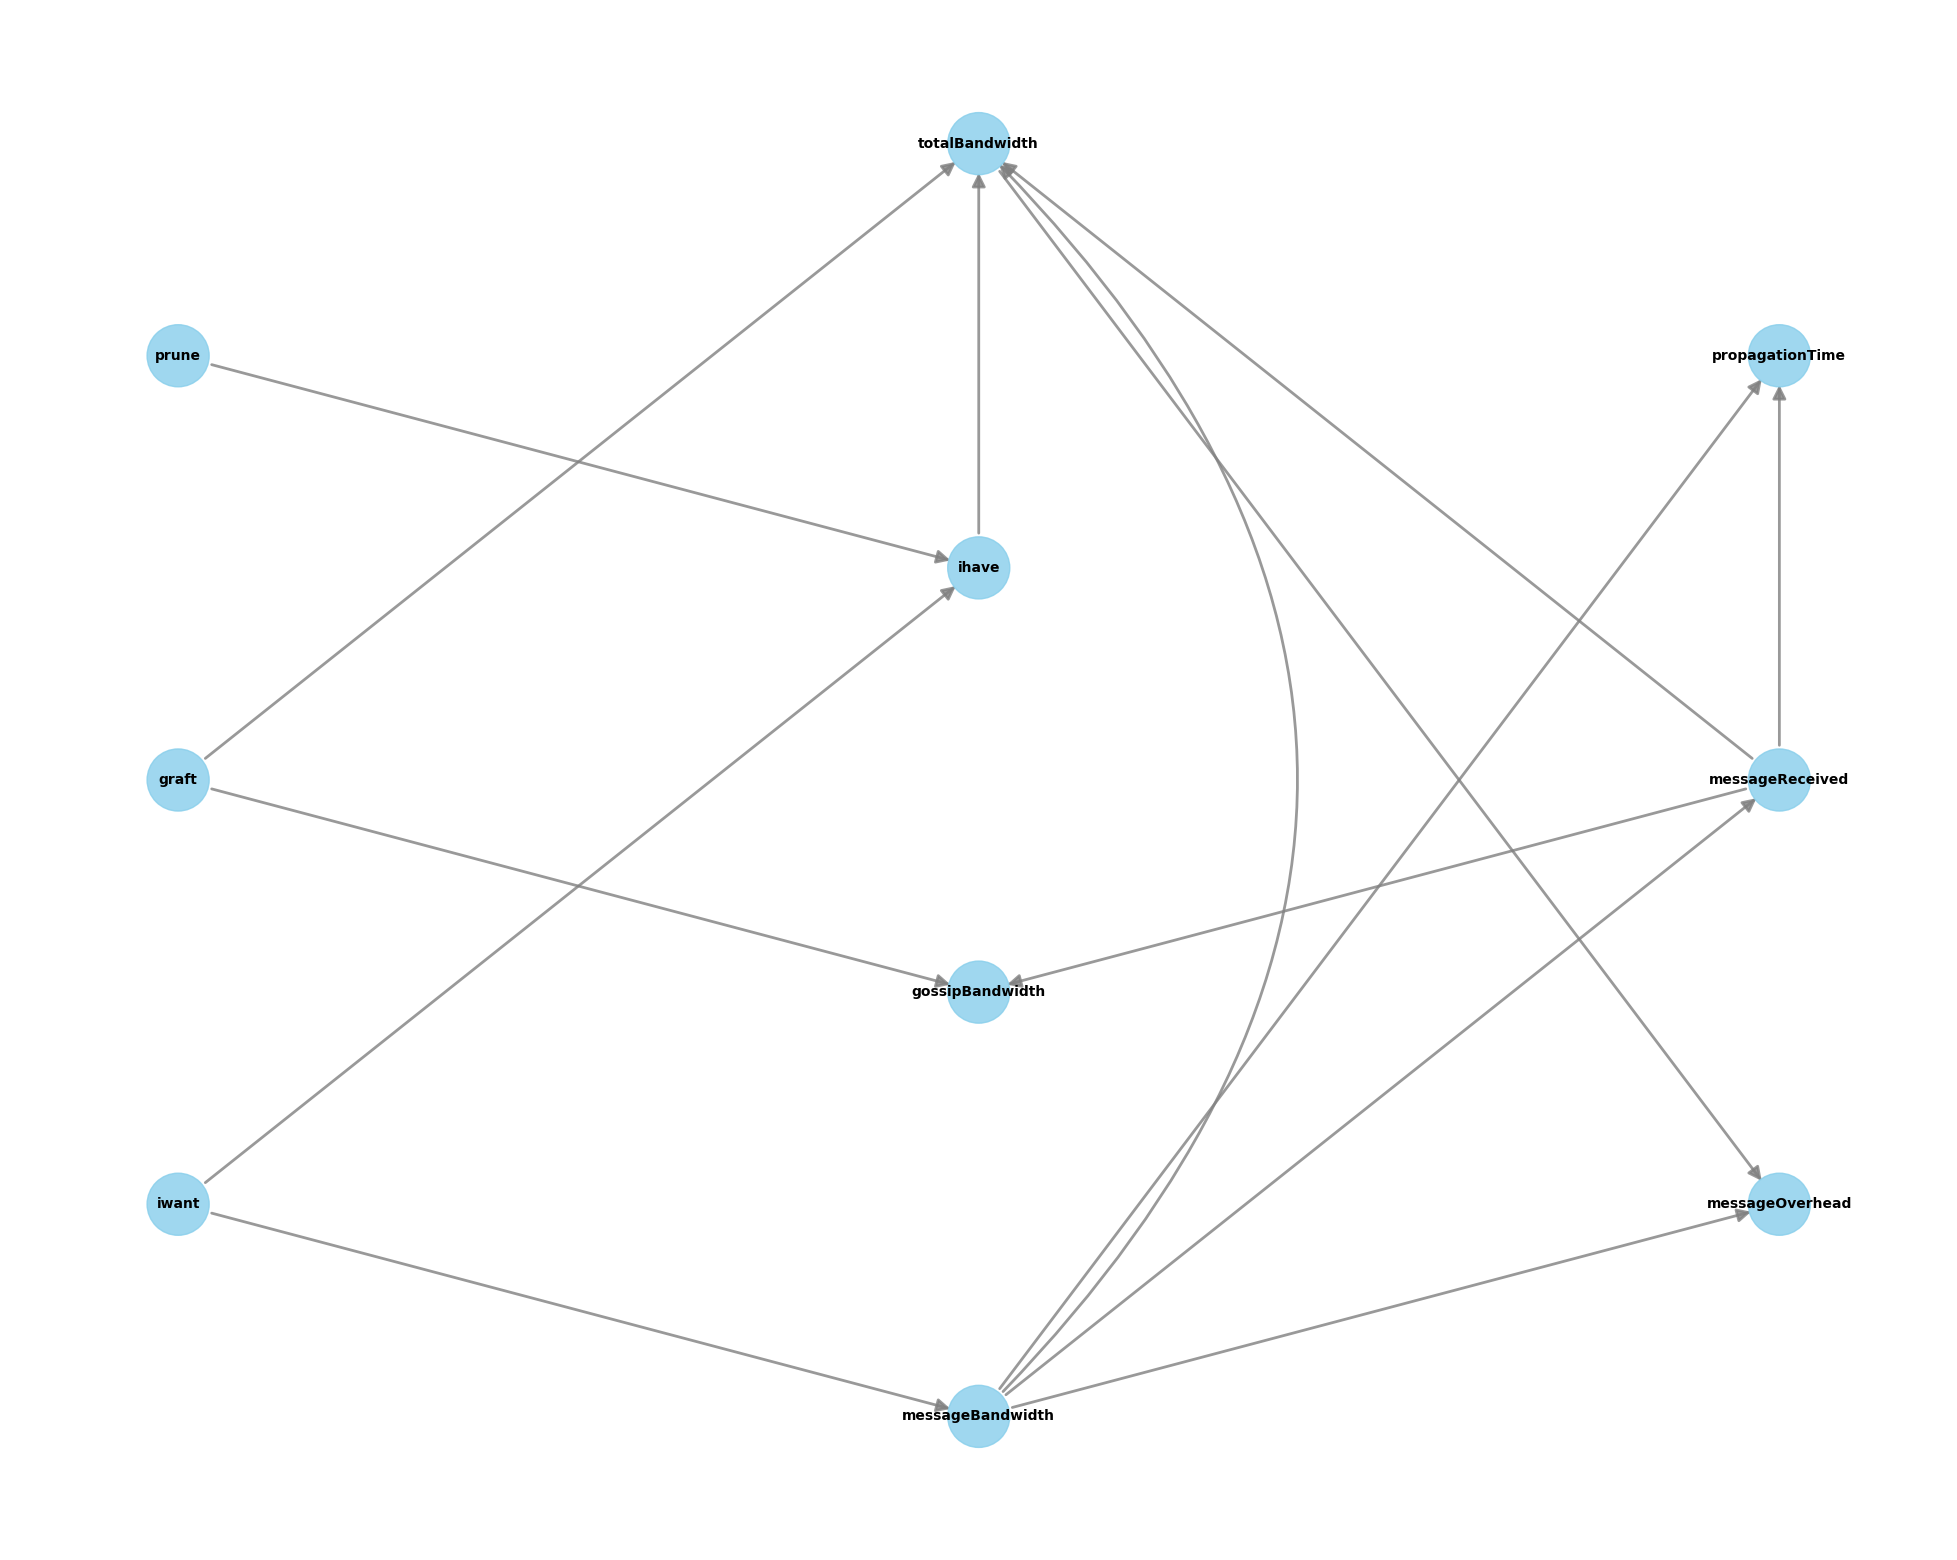

In [23]:
learned_causal_graph = nx.from_numpy_array(g.causal_matrix, create_using=nx.DiGraph)

mapping = {
            0:'prune', 
            1:'graft', 
            2:'propagationTime', 
            3:'messageReceived', 
            4:'messageOverhead', 
            5:'totalBandwidth', 
            6:'ihave', 
            7:'gossipBandwidth', 
            8:'iwant', 
            9:'messageBandwidth'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "directLingam.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

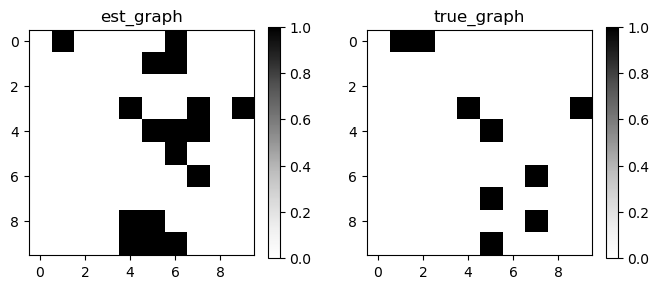

{'fdr': 0.9286, 'tpr': 0.1111, 'fpr': 0.3611, 'shd': 19, 'nnz': 14, 'precision': 0.0714, 'recall': 0.1111, 'F1': 0.087, 'gscore': 0.0}


In [27]:
g2 = ICALiNGAM()
g2.learn(X)

# plot est_dag and true_dag
GraphDAG(g2.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(g.causal_matrix, true_causal_matrix)
print(met.metrics)

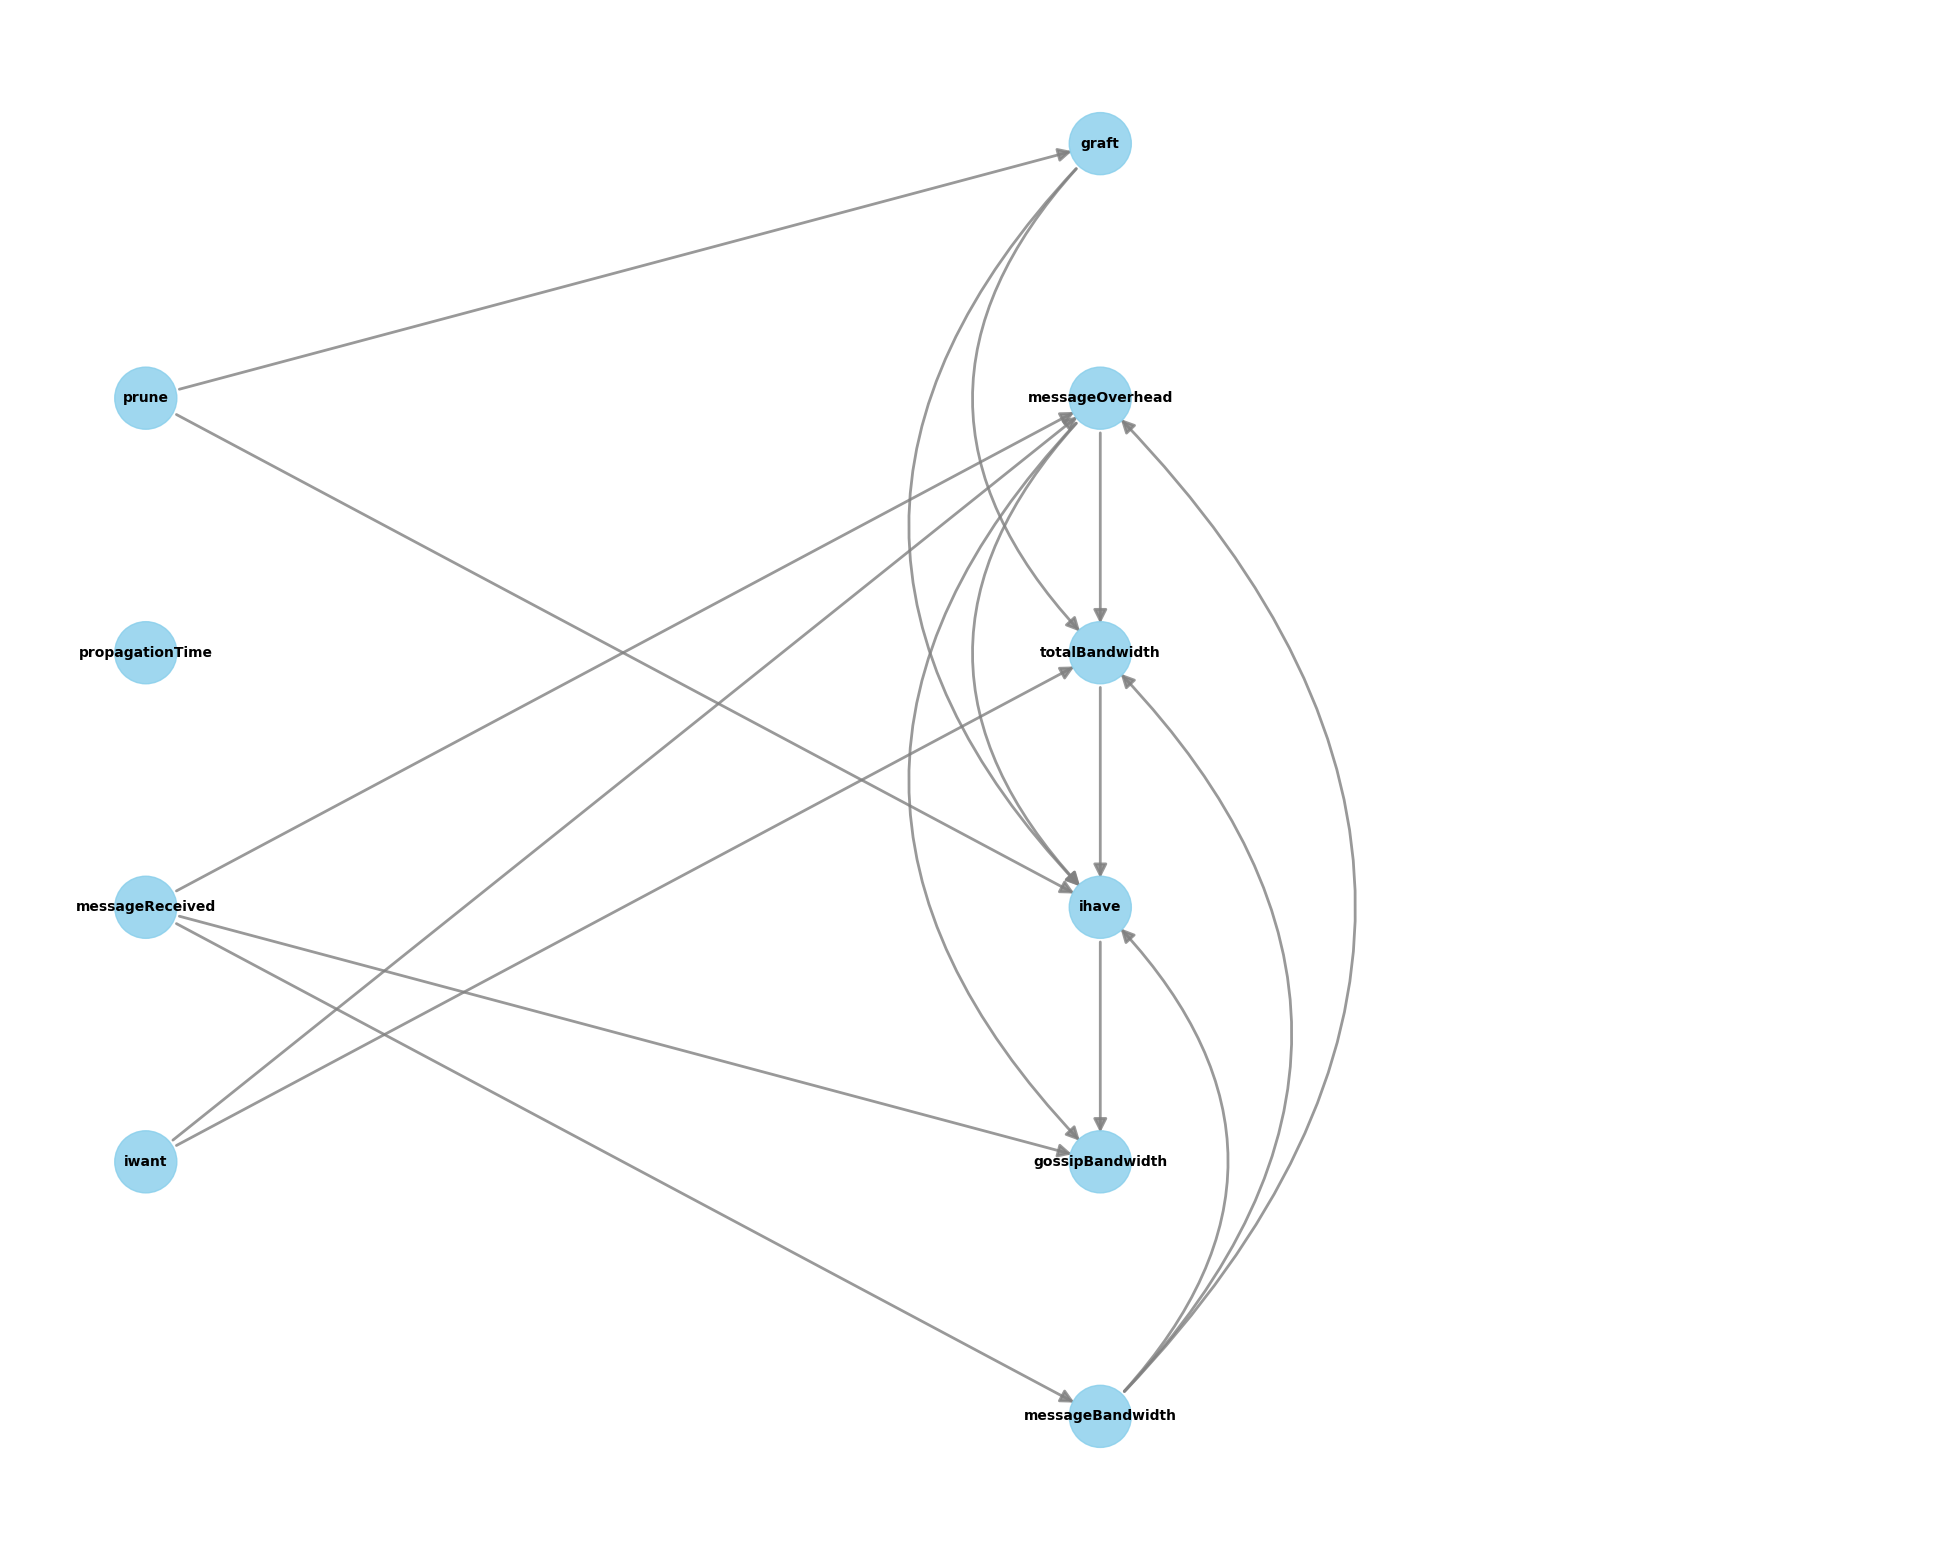

In [28]:
learned_causal_graph = nx.from_numpy_array(g2.causal_matrix, create_using=nx.DiGraph)

mapping = {
            0:'prune', 
            1:'graft', 
            2:'propagationTime', 
            3:'messageReceived', 
            4:'messageOverhead', 
            5:'totalBandwidth', 
            6:'ihave', 
            7:'gossipBandwidth', 
            8:'iwant', 
            9:'messageBandwidth'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "ICALingam.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [24]:
consolidated = cons.loc[cons['experiment'].isin([447,448,449,563])]

# consolidated = consolidated.drop(columns=['experiment'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})#, 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
consolidated = consolidated.drop(columns=['top', 'd', 'dhi', 'dlo','dscore','dout','gossipFactor','dlazy','interval'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['prune', 'graft', 'propagationTime', 'messageReceived', 'messageOverhead', 'totalBandwidth', 'ihave', 'gossipBandwidth', 'iwant', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,experiment,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,topology
31790,447,1321.402778,646.0,90.0,0.0,0.0,0.0,0.0,90.0,1466.0,1116.0,1
31791,447,1621.190476,552.0,74.0,0.0,0.0,0.0,0.0,74.0,1249.0,363.0,1
31792,447,1847.813953,557.0,75.0,0.0,0.0,0.0,0.0,75.0,1262.0,366.0,1
31793,447,1419.576471,990.0,135.0,0.0,0.0,0.0,0.0,135.0,2244.0,1116.0,1
31794,447,1349.629630,218.0,29.0,0.0,0.0,0.0,238.0,30.0,615.0,365.0,1
31795,447,1400.390805,998.0,134.0,0.0,0.0,0.0,0.0,135.0,2261.0,1122.0,1
31796,447,1151.464286,219.0,30.0,0.0,0.0,0.0,239.0,30.0,616.0,362.0,1
31797,447,1410.348837,988.0,135.0,0.0,0.0,0.0,0.0,135.0,2235.0,1112.0,1
31798,447,1127.964286,219.0,29.0,0.0,0.0,0.0,240.0,30.0,620.0,366.0,1
31799,447,1734.278261,1202.0,165.0,0.0,0.0,0.0,0.0,165.0,2729.0,1116.0,1


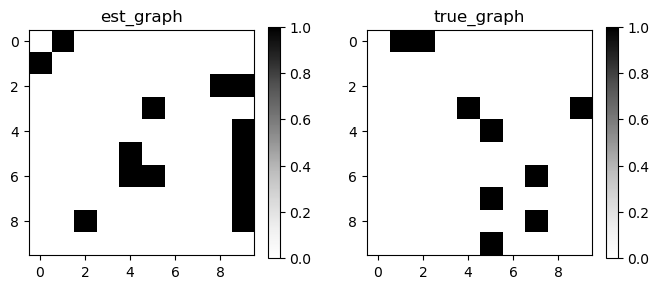

{'fdr': 0.9167, 'tpr': 0.1111, 'fpr': 0.3056, 'shd': 17, 'nnz': 12, 'precision': 0.0714, 'recall': 0.1111, 'F1': 0.087, 'gscore': 0.0}


In [25]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
# priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
#                             (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
#                             (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
#                             (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
#                             (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
#                             (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
#                             (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
#                             (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
#                             (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
#                             (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15),(14,4),(16,17),(16,18)])
# priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original')#, priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

In [ ]:
learned_causal_graph = nx.from_numpy_array(g2.causal_matrix, create_using=nx.DiGraph)

mapping = {
            0:'prune', 
            1:'graft', 
            2:'propagationTime', 
            3:'messageReceived', 
            4:'messageOverhead', 
            5:'totalBandwidth', 
            6:'ihave', 
            7:'gossipBandwidth', 
            8:'iwant', 
            9:'messageBandwidth'}

# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab